# Actual Results
## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts

from io import StringIO

import zipfile
import os

## Load data

In [2]:
weather_data = pd.DataFrame()

for file in os.listdir("weather-data"):
    with open(f"weather-data/{file}") as f:
        data = f.read()
        data = data[data.find("#")+1:]
        curr_data = pd.read_csv(StringIO(data), low_memory=False)
        weather_data = pd.concat([weather_data, curr_data])
    
weather_data.columns = weather_data.columns.str.strip()
weather_data: pd.DataFrame = weather_data.apply(pd.to_numeric, errors='coerce')
date = pd.to_datetime(weather_data["YYYYMMDD"].astype(str) + (weather_data["HH"] - 1).astype(str).str.zfill(2), format="%Y%m%d%H", errors='coerce')
weather_data = pd.concat([date, weather_data], axis=1)
weather_data.rename({0: "date"}, axis=1, inplace=True)
weather_data.loc[:, "RH-fix"] = weather_data["RH"].replace({-1: 0}) / 10
weather_data.set_index(["date", "STN"], inplace=True)
weather_data.to_hdf("weather_data.hdf5", "measured_data")
weather_data

,,YYYYMMDD,HH,DD,FH,FF,FX,T,T10N,TD,SQ,...,N,U,WW,IX,M,R,S,O,Y,RH-fix
date,STN,,,,,,,,,,,,,,,,,,,,,
1971-01-01 00:00:00,240,19710101,1,140,15.0,10,26.0,-87,NaN,-95.0,NaN,...,9.0,93.0,49.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0
1971-01-01 01:00:00,240,19710101,2,130,10.0,10,26.0,-80,NaN,-87.0,NaN,...,9.0,94.0,49.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0
1971-01-01 02:00:00,240,19710101,3,190,10.0,10,21.0,-73,NaN,-80.0,NaN,...,9.0,94.0,49.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0
1971-01-01 03:00:00,240,19710101,4,210,10.0,10,21.0,-77,NaN,-84.0,NaN,...,9.0,94.0,49.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0
1971-01-01 04:00:00,240,19710101,5,190,15.0,15,21.0,-84,NaN,-91.0,NaN,...,9.0,94.0,49.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,260,20201231,20,220,10.0,10,20.0,14,NaN,10.0,0.0,...,8.0,96.0,10.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-31 20:00:00,260,20201231,21,290,10.0,10,20.0,6,NaN,4.0,0.0,...,1.0,98.0,34.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-12-31 21:00:00,260,20201231,22,200,10.0,10,20.0,-10,NaN,-13.0,0.0,...,3.0,98.0,35.0,7.0,1.0,0.0,0.0,0.0,1.0,0.0


## Average rain per day

<AxesSubplot:xlabel='date'>

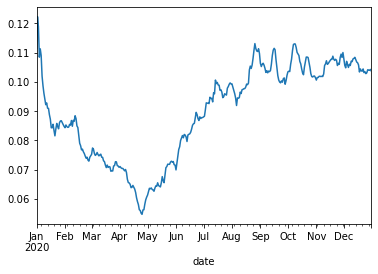

In [3]:
day_rainfall = weather_data.groupby([weather_data.index.get_level_values(0).month, weather_data.index.get_level_values(0).day]).mean()["RH-fix"]
day_rainfall.index = pd.to_datetime("2020" + day_rainfall.index.get_level_values(0).astype(str).str.zfill(2) + day_rainfall.index.get_level_values(1).astype(str).str.zfill(2), format="%Y%m%d")
day_rainfall.ewm(14).mean().plot()

## Rain per hour

<AxesSubplot:xlabel='date'>

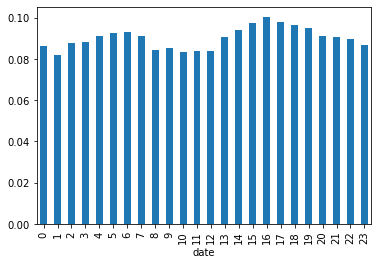

In [4]:
weather_data.groupby(weather_data.index.get_level_values(0).hour).mean()["RH-fix"].plot.bar()

## Rain per station

STN
240    0.091861
260    0.093606
310    0.084906
Name: RH-fix, dtype: float64

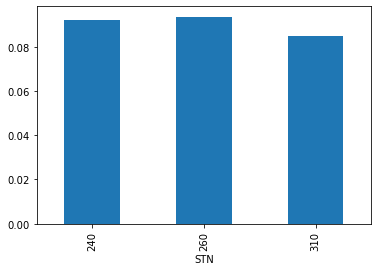

In [5]:
weather_data.groupby("STN").mean()["RH-fix"].plot.bar()
weather_data.groupby("STN").mean()["RH-fix"]

Het is dus geen geometric distribution

## Probability of rain per day

<AxesSubplot:xlabel='date'>

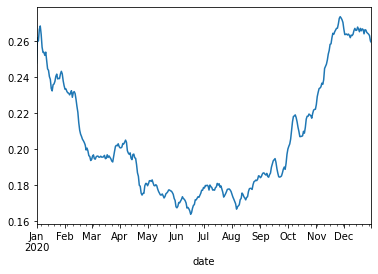

In [6]:
day_rainfall = weather_data.groupby([weather_data.index.get_level_values(0).month, weather_data.index.get_level_values(0).day]).mean()["R"]
day_rainfall.index = pd.to_datetime("2020" + day_rainfall.index.get_level_values(0).astype(str).str.zfill(2) + day_rainfall.index.get_level_values(1).astype(str).str.zfill(2), format="%Y%m%d")
day_rainfall.ewm(14).mean().plot()

## Probability of rain per hour

<AxesSubplot:xlabel='date'>

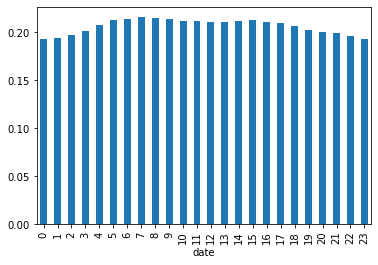

In [7]:
weather_data.groupby(weather_data.index.get_level_values(0).hour).mean()["R"].plot.bar()

## If it rains, how much does it rain?

<AxesSubplot:xlabel='date'>

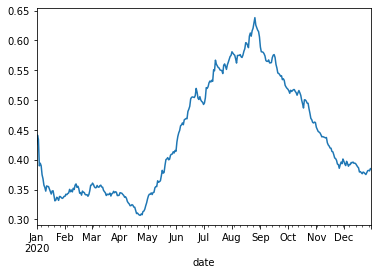

In [8]:
rain_if_falling = weather_data[weather_data["R"] == 1]["RH-fix"]

day_rainfall = rain_if_falling.groupby([rain_if_falling.index.get_level_values(0).month, rain_if_falling.index.get_level_values(0).day]).mean()
day_rainfall.index = pd.to_datetime("2020" + day_rainfall.index.get_level_values(0).astype(str).str.zfill(2) + day_rainfall.index.get_level_values(1).astype(str).str.zfill(2), format="%Y%m%d")
day_rainfall.ewm(14).mean().plot()

## Rain over the years

<AxesSubplot:xlabel='date'>

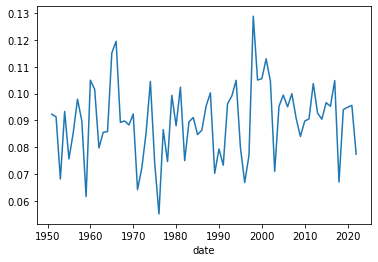

In [13]:
weather_data.groupby(weather_data.index.get_level_values(0).year).mean()["RH-fix"].plot()